In [1]:
import os
import sys

import pandas as pd

pd.set_option("mode.copy_on_write", True)

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning

jobs = cleaning.prep(
    pd.read_pickle("../data/jobs.pkl"), filtered=False, categories_reduced=False
)
# jobs.head()

In [2]:
jobs = jobs[
    (jobs["Profile"] != "Nicht stepstone")
    & (jobs["Profile"] != "Stellenanzeige nicht mehr verfügbar")
    & (jobs["Profile"] != "")
]
texts = jobs["Profile"]

In [3]:
import pickle
import re

import nltk
from HanTa import HanoverTagger as ht
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def tokenize_doc(doc):
    stopwords_ger = stopwords.words("german")
    stopwords_ger.extend(["du", "sie"])
    stopwords_en = stopwords.words("english")

    cleaned = re.sub(
        r"[\W](?=\w)",
        " ",
        doc.replace("\u200b", " ")
        .replace("\xad", "")
        .replace("-", " ")
        .replace("/", " ")
        .replace("·", " ")
        .replace("•", " ")
        .replace("…", " "),
    )
    tokenized = word_tokenize(cleaned, language="german")
    alphas = [w.lower() for w in tokenized if w.isalpha()]

    tagger = ht.HanoverTagger("morphmodel_ger.pgz")

    no_stops_de = [w for w in alphas if w not in stopwords_ger]
    no_stops_de_en = [w for w in no_stops_de if w not in stopwords_en]

    lemmatized = [tagger.analyze(token)[0].lower() for token in no_stops_de_en]

    return lemmatized

In [5]:
if os.path.isfile("../data/lemmatized_profile.pkl"):
    with open("../data/lemmatized_profile.pkl", "rb") as file:
        old_lemmas = pickle.load(file)
else:
    old_lemmas = []

lemmas = old_lemmas

docs = [doc for doc in texts]

In [6]:
if len(docs) > len(old_lemmas):
    new_docs = docs[len(old_lemmas) :]
    docs_count = len(new_docs)
    new_lemmas = []
    print(f"Tokenizing {docs_count} documents")
    i = 1
    for doc in new_docs:
        if i % 500 == 0:
            print(f"{i}/{docs_count}")
        new_lemmas.append(tokenize_doc(doc))
        i += 1
    lemmas += new_lemmas

    with open("../data/lemmatized_profile.pkl", "wb") as file:
        pickle.dump(lemmas, file)

Tokenizing 15746 documents
500/15746
1000/15746
1500/15746
2000/15746
2500/15746
3000/15746
3500/15746
4000/15746
4500/15746
5000/15746
5500/15746
6000/15746
6500/15746
7000/15746
7500/15746
8000/15746
8500/15746
9000/15746
9500/15746
10000/15746
10500/15746
11000/15746
11500/15746
12000/15746
12500/15746
13000/15746
13500/15746
14000/15746
14500/15746
15000/15746
15500/15746


In [7]:
from collections import Counter

all_in_one = [w for doc in lemmas for w in doc]
bow = Counter(all_in_one)
bow.most_common(10)

[('gut', 13317),
 ('erfahrung', 10945),
 ('sowie', 10138),
 ('kenntnis', 9388),
 ('abgeschlossen', 8814),
 ('bereich', 8544),
 ('studium', 7834),
 ('haben', 7772),
 ('experience', 6305),
 ('vergleichbar', 6295)]

In [8]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

dictionary = Dictionary(lemmas)
bow_corpus = [dictionary.doc2bow(doc) for doc in lemmas]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# BOW

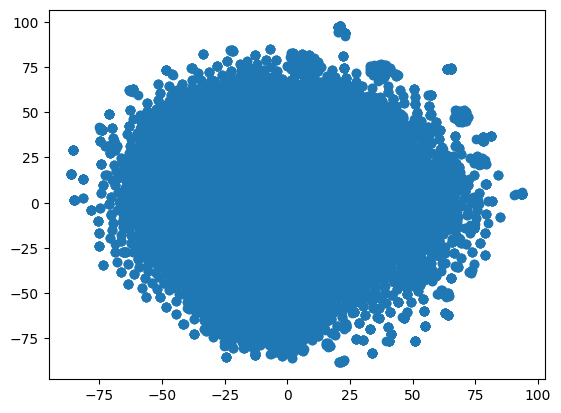

In [9]:
import matplotlib.pyplot as plt
from gensim import matutils
from sklearn.manifold import TSNE

sklearn_vectors = matutils.corpus2csc(bow_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [10]:
import pyLDAvis
import pyLDAvis.gensim
from gensim.models.ldamulticore import LdaMulticore

lda_model = LdaMulticore(
    corpus=bow_corpus,
    workers=2,
    id2word=dictionary,
    num_topics=5,
    random_state=100,
    chunksize=50,
    passes=10,
    per_word_topics=True,
)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.223665 -0.241482       1        1  59.853671
0      0.286032 -0.157249       2        1  22.413911
1     -0.206808  0.111134       3        1   8.774413
3      0.109143  0.051446       4        1   7.147852
2      0.035297  0.236151       5        1   1.810154, topic_info=                 Term          Freq         Total Category  logprob  loglift
14               data   6235.000000   6235.000000  Default  30.0000  30.0000
97         experience   6035.000000   6035.000000  Default  29.0000  29.0000
132               gut  13150.000000  13150.000000  Default  28.0000  28.0000
108            skills   3519.000000   3519.000000  Default  27.0000  27.0000
22          erfahrung  10384.000000  10384.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
112              team    106.966996   4349.211148   Topic5  -5.0139   0.3065
2678          täglich     51.854093    188.195408   Topic5  -5.7379   2.7227
106           problem     65.687168   1112.760312   Topic5  -5.5015   1.1821
1719           erfolg     51.484403    398.626693   Topic5  -5.7451   1.9650
447   eigeninitiative     47.632723   1185.213755   Topic5  -5.8229   0.7976

[290 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
117       1  0.999928  abgeschlossen
89        2  0.999156        ability
1176      2  0.251572          activ
1176      5  0.743014          activ
1         1  0.464035           agil
...     ...       ...            ...
63        4  0.203675              z
975       1  0.999543       zeichnen
3490      3  0.992658           zeit
3010      1  0.234203         zielen
3010      3  0.765063         zielen

[400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3])

In [11]:
def calc_topic_for_doc(doc):
    values = []
    tuples = lda_model.get_document_topics(doc)
    for tuple in tuples:
        values.append(tuple[1])
    max_prob = max(values)
    topic = tuples[values.index(max_prob)][0]
    return topic + 1

In [12]:
bow_topic_list = []
for doc in bow_corpus:
    bow_topic_list.append(calc_topic_for_doc(doc))

df_bow = pd.DataFrame(
    {"topics": bow_topic_list, "Job_Kategorie": jobs["Job Kategorie"]}, index=jobs.index
)

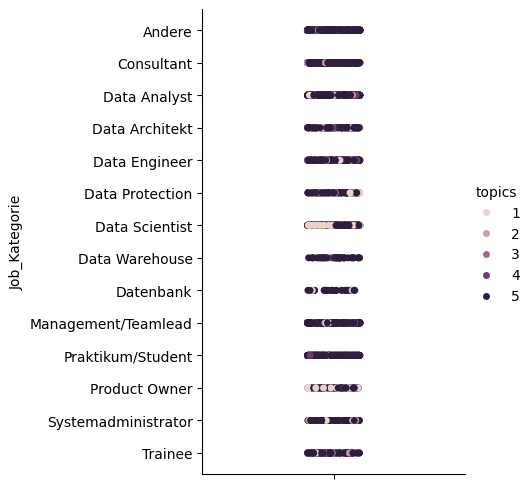

In [13]:
import seaborn as sns

sns.catplot(data=df_bow, hue="topics", y="Job_Kategorie")

# TF-IDF

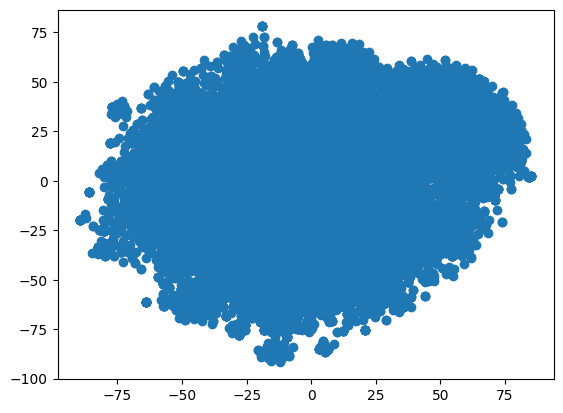

In [14]:
sklearn_vectors = matutils.corpus2csc(tfidf_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [15]:
lda_model = LdaMulticore(
    corpus=tfidf_corpus,
    workers=2,
    id2word=dictionary,
    num_topics=3,
    random_state=100,
    chunksize=50,
    passes=10,
    per_word_topics=True,
)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, tfidf_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.186829 -0.009048       1        1  70.622543
2     -0.112100 -0.063327       2        1  22.436856
0     -0.074728  0.072376       3        1   6.940602, topic_info=                   Term        Freq       Total Category  logprob  loglift
97           experience  108.000000  108.000000  Default  30.0000  30.0000
108              skills   75.000000   75.000000  Default  29.0000  29.0000
70                haben  283.000000  283.000000  Default  28.0000  28.0000
101            knowledg   50.000000   50.000000  Default  27.0000  27.0000
669             english   48.000000   48.000000  Default  26.0000  26.0000
...                 ...         ...         ...      ...      ...      ...
3766         onboarding    2.359792    5.150655   Topic3  -7.9143   1.8872
1424               home    1.888241    4.830611   Topic3  -8.1373   1.7285
4288  chancengleichheit    1.882725    5.002463   Topic3  -8.1402   1.6906
8487            eignung    1.800048    6.414836   Topic3  -8.1851   1.3970
3309               wert    1.783732   16.271816   Topic3  -8.1942   0.4571

[152 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
12644      3  0.536875             abbrechen
117        1  0.995797         abgeschlossen
89         2  0.981346               ability
7302       3  0.806396                ablauf
21960      3  0.766409  academyprofessionell
...      ...       ...                   ...
635        2  0.989597               working
154        1  0.995787                  wort
1205       2  0.999276               written
1175       2  0.999972                  year
63         1  0.997851                     z

[154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [16]:
tfidf_topic_list = []
for doc in tfidf_corpus:
    tfidf_topic_list.append(calc_topic_for_doc(doc))

df_tfidf = pd.DataFrame(
    {"topics": tfidf_topic_list, "Job_Kategorie": jobs["Job Kategorie"]},
    index=jobs.index,
)

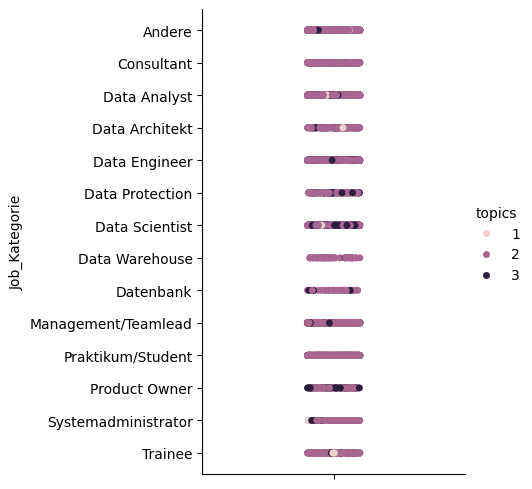

In [17]:
sns.catplot(data=df_tfidf, hue="topics", y="Job_Kategorie")